In [582]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

In [583]:
#Converting data to torch.FloatTensor
transform = transforms.ToTensor()

# Download the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
#Now, we will prepare the data loaders that will be used for training and testing.

batch_size=32

#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


In [584]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [585]:
#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

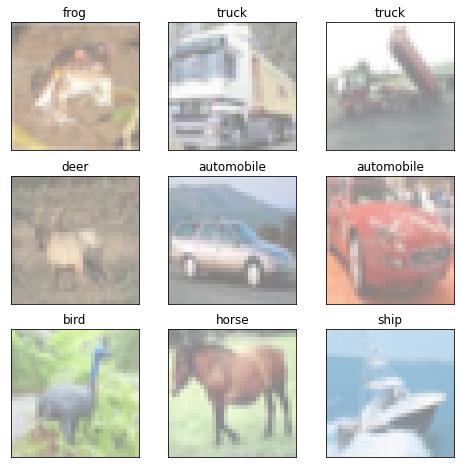

In [586]:
#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

frog  truck truck deer  automobile automobile bird  horse ship  cat   deer  horse horse bird  truck truck truck cat   bird  frog  deer  cat   frog  frog  bird  frog  cat   dog   deer  airplane airplane truck


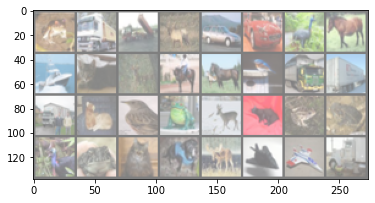

In [587]:
def imshow2(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [588]:
class VAE(nn.Module):
    '''
     net = MyVAE(img_size=28, embedding_dim=2)
     
     Create an autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images
                      Input samples will be (img_size**2) vectors.
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = MyAE()
       y = net(x)         # returns output
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=32, embedding_dim=128):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        act : object = nn.GELU
        
        c_hid = 64
        self.encode = nn.Sequential(
            nn.Conv2d(3, c_hid, kernel_size = 3, padding = 1, stride = 2),
            act(),
            nn.Conv2d(c_hid, c_hid, kernel_size = 3, padding = 1),
            act(),
            nn.Conv2d(c_hid, c_hid*2, kernel_size=3, padding=1, stride=2),
            act(),
            nn.Conv2d(c_hid*2, c_hid*2 , kernel_size = 3, padding =1),
            act(),
            nn.Conv2d(c_hid*2, c_hid*2, kernel_size=3, padding=1, stride=2),
            act(),
            nn.Flatten(), # Image grid to single feature vector
            #nn.Linear((2*16*32), embedding_dim),
            #nn.Sigmoid(),
            )
        
        # distribution parameters
        self.fc_mu = nn.Linear(2*16*32, embedding_dim)
        self.fc_var = nn.Linear(2*16*32, embedding_dim)
        
        self.linear = nn.Sequential(
            nn.Linear(self.embedding_dim, (2*16*32)),
            act()
        )

        self.decode = nn.Sequential(   
            nn.ConvTranspose2d((c_hid*2), (c_hid*2), kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act(),
            nn.Conv2d((c_hid*2), (c_hid*2), kernel_size = 3, padding = 1), 
            act(),
            nn.ConvTranspose2d((c_hid*2), c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act(),
            nn.Conv2d((c_hid), (c_hid), kernel_size = 3, padding = 1), 
            act(),
            nn.ConvTranspose2d(c_hid, 3, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            #nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
            nn.Sigmoid()
            )
        
    def forward(self, x):
        h = self.encode(x)
        
        mu, log_var = self.fc_mu(h), self.fc_var(h)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        ha = self.linear(z)
        hb = ha.reshape(ha.shape[0], -1, 4, 4)
        y = self.decode(hb)
        return y, mu, log_var

In [589]:
#Instantiate the model
#model = ConvAutoencoder()
model = VAE()
print(model)

VAE(
  (encode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
  (fc_var): Linear(in_features=1024, out_features=128, bias=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): GELU()
  )
  (decode): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [590]:
#Loss function & Optimizer
criterion = nn.MSELoss()
#criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters())

In [591]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + 0.000003*KLD

In [592]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
#device = 'cpu'
print(device)
model.to(device)


cuda:0


VAE(
  (encode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
  (fc_var): Linear(in_features=1024, out_features=128, bias=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): GELU()
  )
  (decode): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [593]:
# #Epochs
# n_epochs = 10 #10

# for epoch in range(1, n_epochs+1):
#     # monitor training loss
#     train_loss = 0.0
#     running_loss = 0.0

#     #Training
#     for data in train_loader:
#         images, _ = data
#         images = images.to(device)
#         optimizer.zero_grad()
#         outputs, mu, logvar = model(images)
#         bce_loss = criterion(outputs, images)
#         loss = final_loss(bce_loss, mu, logvar)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()*images.size(0)
          
#     train_loss = train_loss/len(train_loader)
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    

In [594]:
# Uncomment the following line if you want to save your network.
#torch.save(model.to('cpu'), 'my_VAE.pt')

# The corresponding code to reload the network is below.
model = torch.load('my_VAE.pt')
# Remember to send it to the GPU, if you're using one.
model.to(device)

VAE(
  (encode): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
  (fc_var): Linear(in_features=1024, out_features=128, bias=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): GELU()
  )
  (decode): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): G

In [595]:
def encoder(imgs):
    ha = model.encode(imgs)
    mua, log_vara = model.fc_mu(ha), model.fc_var(ha)
    # sample z from q
    stda = torch.exp(log_vara / 2)
    qa = torch.distributions.Normal(mua, stda)
    za = qa.rsample()
    
    return za

def decoder(enc):
    #Decodes a point in a latent space back to image
    haa = model.linear(enc)
    hba = haa.reshape(1, -1, 4, 4)
    y = model.decode(hba)
    
    return y

def findMidPoint(p, ea, eb):
    mid = (ea + eb)/2
    
    return mid

def findEpsPoint(p, ea, eb):
    newa = p*ea + ((1-p)*eb)
    
    return newa

#Utility functions to un-normalize and display an image
def showImage(y):
    y = y.to('cpu')
    y = y.view(3, 32, 32)
    with torch.no_grad():
        y = y / 2 + 0.5  
        plt.imshow(np.transpose(y, (1, 2, 0))) 

In [596]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
#Sample outputs
output, mu, std = model(images)

images = images.to('cpu')
#images = images.numpy()

output = output.to('cpu')
output = output.view(batch_size, 3, 32, 32)
#output = output.detach().numpy()

#imshow2(utils.make_grid(output))
#imshow2(utils.make_grid(images))

imagesa, labelsa = dataiter.next()
imagesa = imagesa.to(device)

zspace = encoder(imagesa)

testPoint = findEpsPoint(0.5, zspace[0], zspace[5])
generatedPoint = decoder(testPoint)

#testPoint.shape
#generatedPoint.shape
# showImage(imagesa[0])
# showImage(imagesa[5])
# showImage(generatedPoint)
#distance = torch.cdist(zspace, zspace, p=2)
#distance1 = torch.cdist(testPoint[None,:],   zspace[0:10], p=2)
#distance1[0][9]

In [640]:
labelsa[10]

tensor(5)

In [597]:
# generatedPoint = generatedPoint.to('cpu')
# with torch.no_grad():
#     t_np = generatedPoint.numpy() #convert to Numpy array
#     np.save('genImage.npy', t_np)

In [598]:
class MyAE(nn.Module):
    '''
     net = MyAE(latent_dim=64, ch_size=3)    
     Inputs:
       latent_dim     number of nodes in embedding (latent) layer.
       ch_size        number of input channels.r
    '''
    def __init__(self, latent_dim=64, ch_size=3):
        self.latent_dim = latent_dim
        self.channels = ch_size
        self.losses = []
        super().__init__()
        
        # Encode
        c_hid = 64
        self.Encoder = nn.Sequential(
            nn.Conv2d(self.channels, c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Flatten(),
            nn.Linear(2*16*c_hid, self.latent_dim)
        )
        
        # Linear Compression
        self.Linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            nn.Sigmoid()
        )
        
        # Decode
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(c_hid, self.channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Tanh()
        )
 
    def forward(self, x):
        
        # Forward pass
        h = self.Encoder(x)
        h = self.Linear(h)
        h_flat = h.reshape(h.shape[0], -1, 4, 4)
        y = self.Decoder(h_flat)
        return y

In [599]:
net = MyAE(latent_dim=128, ch_size=3)

In [600]:
##Loading AE model to do image search

# The corresponding code to reload the network is below.
net = torch.load('CIFAR_AE_128.pt')
# Remember to send it to the GPU, if you're using one.
#net.to(device)

In [601]:
generatedPoint = generatedPoint.to('cpu')
searchZ = net.Encoder(generatedPoint)
#outAE = net(generatedPoint)
#generatedPoint = generatedPoint.view(3,32,32)
#searchZ = searchZ.view(128)
#outAE = net(images)
# with torch.no_grad():
#     imshow(torchvision.utils.make_grid(generatedPoint))

In [602]:
generatedPoint = generatedPoint.view(3,32,32)
searchZ = searchZ.view(128)
searchZ.shape

torch.Size([128])

In [603]:
def embedding(model, data_loader):
    """ Encodes all the images in the data loader """
    images = []
    embedded = []
    labels =[]
    for input, label in (data_loader):
        #print(input.shape)
        with torch.no_grad():
            z = model.Encoder(input)
        images.append(input)
        embedded.append(z)
        print(z.shape)
        labels.append(label)
    return (torch.cat(images, dim=0), torch.cat(embedded, dim=0),torch.cat(labels, dim =0))

In [604]:
train_embeds = embedding(net, train_loader)
test_embeds = embedding(net, test_loader)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size

In [628]:
def find_similar_images(distance_type, query_img, query_class, query_z, key_embeds, K=5):
    """Finds K closest images to the input image based on euclidean distance between the embedded points """

    #print('You have selected an image of the ' + str(query_class) + ' class')
    #print('Selected distance type is: '+ distance_type)
    
    if distance_type == 'Euclidean':
        #print( key_embeds[1].shape)
        distance = torch.cdist(query_z[None,:], key_embeds[1], p=2)

    if distance_type == 'Cosine':
      cos = nn.CosineSimilarity(dim=1, eps=1e-9)
      distance = cos(query_z[None,:],  key_embeds[1])

    if distance_type == 'Pairwise':
      pair = nn.PairwiseDistance(p =2)
      distance = pair(query_z[None,:],  key_embeds[1])
      
    distance = distance.squeeze(dim=0)
    distance, indices = torch.sort(distance)
    #print("Distance")
    #print(distance.shape)
    #print(indices.shape)
    

    
    input_image = torch.cat([query_img[None]], dim =0)
    grid_input = torchvision.utils.make_grid(input_image, nrow=1, normalize=True, range=(-1,1))
    #print('Selected image')
    grid_input = grid_input.permute(1, 2, 0)
#     plt.figure(figsize=(1.5,1.5))
#     plt.axis('off')
#     plt.imshow(grid_input)
#     plt.show()
#     print('Similar images are:')
    #print(K)
    imgs_to_display = torch.cat([key_embeds[0][indices[:K]]], dim=0)
    index = indices[:K]
    #print(imgs_to_display.shape)
    #print(index.shape)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(9,2))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    c = []
    
    return distance

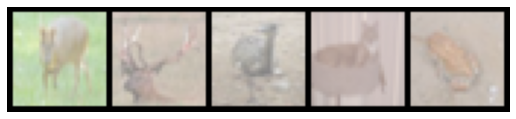

tensor([ 2.5572,  2.5817,  2.5822,  ..., 20.0309, 21.2100, 21.5425],
       grad_fn=<SortBackward0>)

In [629]:
find_similar_images('Euclidean', generatedPoint, 0, searchZ, key_embeds=train_embeds)

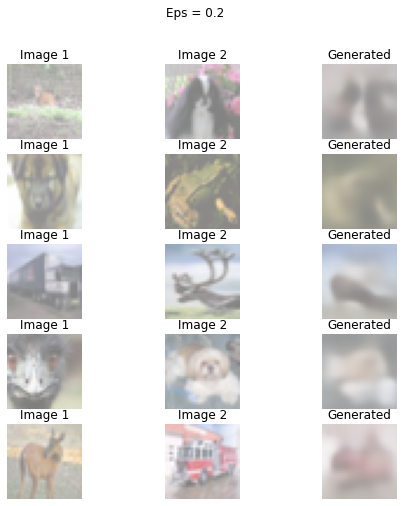

In [630]:
#Plot the images
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Eps = 0.2')

genTestImages = []
rows = 5
j = 0
# display 20 images
for i in range(rows):
    testPoint = findEpsPoint(0.2, zspace[i], zspace[10-i])
    generatedPoint2 = decoder(testPoint)
    genTestImages.append(generatedPoint2)
    
    #ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    plt.subplot(rows,3,j+1)
    plt.title("Image 1")
    plt.axis('off')
    showImage(imagesa[i])
    
    #ax = fig.add_subplot(3, 3, i+2, xticks=[], yticks=[])
    plt.subplot(rows,3,j+2)
    plt.title("Image 2")
    plt.axis('off')
    showImage(imagesa[10-i])
    
    #ax = fig.add_subplot(3, 3, i+3, xticks=[], yticks=[])
    plt.subplot(rows,3,j+3)
    plt.title("Generated")
    plt.axis('off')
    showImage(genTestImages[i])
    j = j + 3

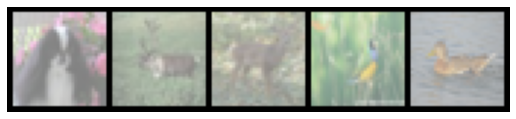

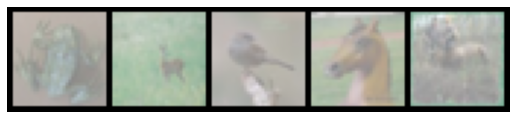

tensor([2.7140, 3.2665, 3.2874, 3.4138, 3.4364], grad_fn=<SliceBackward0>)
tensor([ 3.1775,  3.2827,  3.3081,  ..., 22.2766, 23.4518, 23.7012],
       grad_fn=<SortBackward0>)
tensor(12.8161, grad_fn=<SelectBackward0>)
tensor(16.8793, grad_fn=<SelectBackward0>)


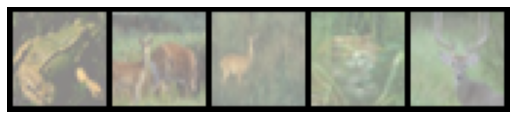

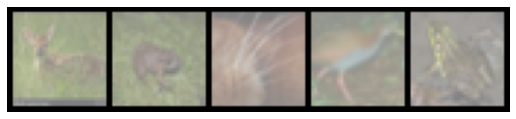

tensor([1.8036, 2.3739, 2.5335, 2.6139, 2.6764], grad_fn=<SliceBackward0>)
tensor([ 2.1731,  2.2668,  2.3044,  ..., 24.5974, 25.9910, 26.1318],
       grad_fn=<SortBackward0>)
tensor(12.6887, grad_fn=<SelectBackward0>)
tensor(14.0696, grad_fn=<SelectBackward0>)


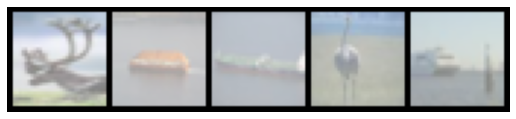

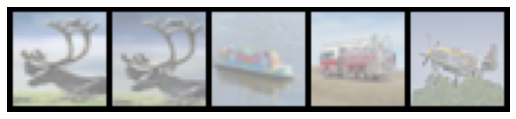

tensor([3.6304, 4.0560, 4.2397, 4.2601, 4.2957], grad_fn=<SliceBackward0>)
tensor([ 3.3512,  3.6704,  3.6846,  ..., 20.6779, 21.6301, 21.7998],
       grad_fn=<SortBackward0>)
tensor(18.7484, grad_fn=<SelectBackward0>)
tensor(17.6869, grad_fn=<SelectBackward0>)


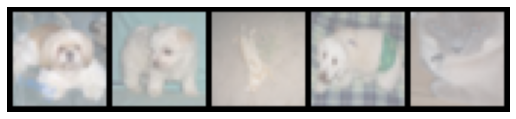

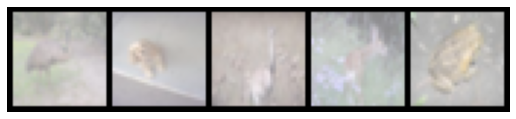

tensor([2.6685, 3.6836, 3.9319, 3.9334, 4.0047], grad_fn=<SliceBackward0>)
tensor([ 3.7322,  3.8223,  3.8336,  ..., 20.0121, 20.7775, 21.0198],
       grad_fn=<SortBackward0>)
tensor(19.1764, grad_fn=<SelectBackward0>)
tensor(17.6951, grad_fn=<SelectBackward0>)


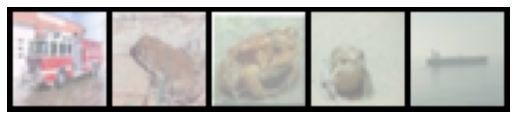

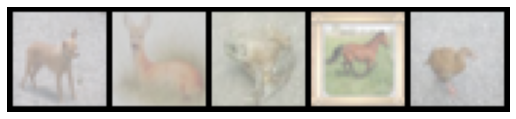

tensor([2.6385, 3.5358, 3.7687, 3.7970, 3.7991], grad_fn=<SliceBackward0>)
tensor([ 3.5299,  3.6900,  3.7051,  ..., 19.1730, 20.3922, 20.6106],
       grad_fn=<SortBackward0>)
tensor(16.5928, grad_fn=<SelectBackward0>)
tensor(18.7603, grad_fn=<SelectBackward0>)


In [631]:
k=0
for generatedPoint in genTestImages:  
    #showImage(imagesa[k])
    generatedPoint = generatedPoint.to('cpu')
    searchZ = net.Encoder(generatedPoint)
    searchZ = searchZ.view(128)
    generatedPoint = generatedPoint.view(3,32,32)
    dis = find_similar_images('Euclidean', generatedPoint, 0, searchZ, key_embeds=test_embeds)
    dis1 = find_similar_images('Euclidean', generatedPoint, 0, searchZ, key_embeds=train_embeds)
    distance = torch.cdist(searchZ[None,:], zspace.to('cpu'), p=2)
    print(dis[0:5])
    print(dis1)
    print(distance[0][k])
    print(distance[0][10-k])
    #showImage(imagesa[9-k])
    k = k + 1

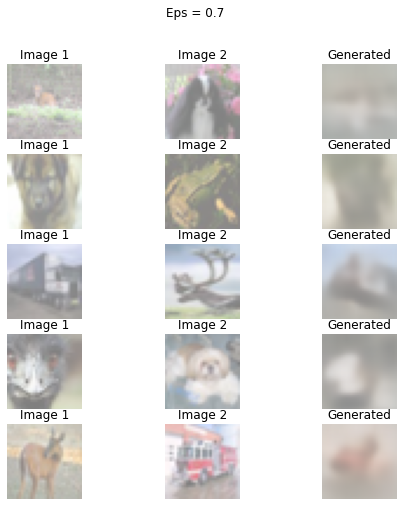

In [632]:
#Plot the images
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Eps = 0.7')

genTestImages7 = []
rows = 5
j = 0
# display 20 images
for i in range(rows):
    testPoint = findEpsPoint(0.7, zspace[i], zspace[10-i])
    generatedPoint7 = decoder(testPoint)
    genTestImages7.append(generatedPoint7)
    
    #ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    plt.subplot(rows,3,j+1)
    plt.title("Image 1")
    plt.axis('off')
    showImage(imagesa[i])
    
    #ax = fig.add_subplot(3, 3, i+2, xticks=[], yticks=[])
    plt.subplot(rows,3,j+2)
    plt.title("Image 2")
    plt.axis('off')
    showImage(imagesa[10-i])
    
    #ax = fig.add_subplot(3, 3, i+3, xticks=[], yticks=[])
    plt.subplot(rows,3,j+3)
    plt.title("Generated")
    plt.axis('off')
    showImage(genTestImages7[i])
    j = j + 3

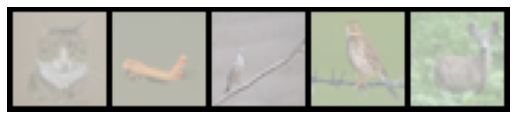

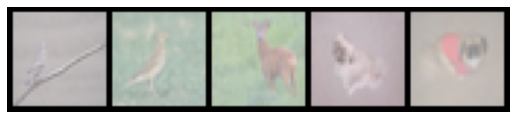

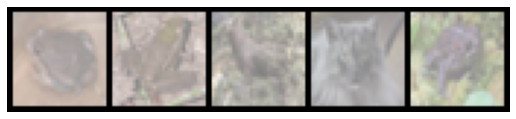

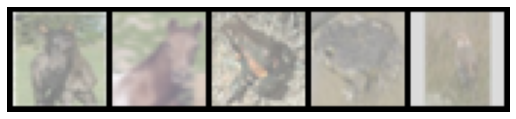

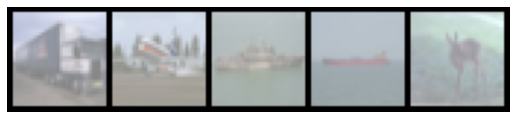

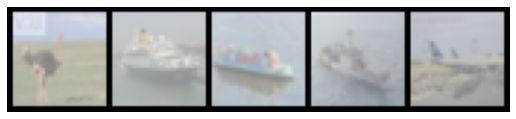

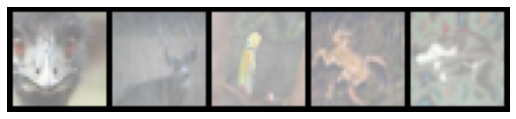

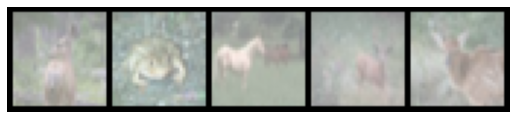

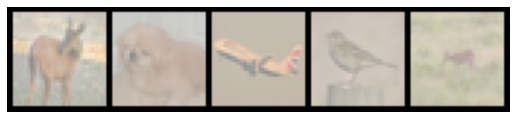

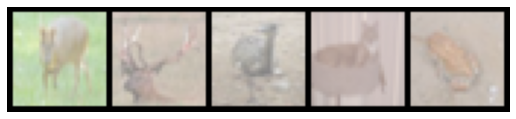

In [633]:
k=0
dis7list = []
dis7list1 = []
for generatedPoint in genTestImages7:  
    #showImage(imagesa[k])
    generatedPoint = generatedPoint.to('cpu')
    searchZ = net.Encoder(generatedPoint)
    searchZ = searchZ.view(128)
    generatedPoint = generatedPoint.view(3,32,32)
    dis = find_similar_images('Euclidean', generatedPoint, 0, searchZ, key_embeds=test_embeds)
    dis1 = find_similar_images('Euclidean', generatedPoint, 0, searchZ, key_embeds=train_embeds)
    distance = torch.cdist(searchZ[None,:], zspace.to('cpu'), p=2)
    #print(dis[0:5])
    #print(dis1[0:5])
    with torch.no_grad():
        dis7list.append(dis[0:5].numpy())
        dis7list1.append(dis1[0:5].numpy())
    #print(distance[0][k])
    #print(distance[0][10-k])
    #showImage(imagesa[9-k])
    k = k + 1

In [634]:
dis7list

[array([1.8365504, 1.996772 , 2.0954947, 2.2803802, 2.3144524],
       dtype=float32),
 array([3.5774949, 3.9035761, 3.9438908, 3.9515285, 3.958107 ],
       dtype=float32),
 array([3.0352442, 3.3081396, 3.365185 , 3.4065926, 3.5699396],
       dtype=float32),
 array([2.6451485, 3.9439654, 3.9749353, 3.9755003, 3.9791806],
       dtype=float32),
 array([1.8434975, 2.683517 , 2.8401983, 2.8845878, 2.9542513],
       dtype=float32)]

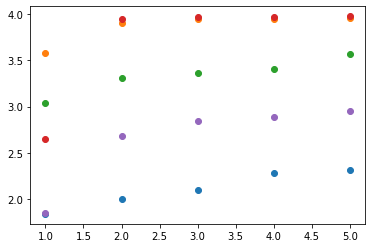

In [636]:
plt.scatter([1,2,3,4,5], dis7list[0])
plt.plot(1, y, marker="*", markersize=20, markeredgecolor="red", markerfacecolor="green")
plt.scatter([1,2,3,4,5], dis7list[1])
plt.scatter([1,2,3,4,5], dis7list[2] )
plt.scatter([1,2,3,4,5], dis7list[3] )
plt.scatter([1,2,3,4,5], dis7list[4] )